In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
data = pd.read_csv('data/predict.csv')

`pip install -r requirements.txt` - установка необходимых библиотек

## 01. Предварительный анализ данных

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   recency                     479 non-null    int64  
 1   topic_rank                  479 non-null    float64
 2   diversity                   479 non-null    float64
 3   authors_mean_rank           473 non-null    float64
 4   authors_mean_hindex         473 non-null    float64
 5   authors_mean_gindex         473 non-null    float64
 6   authors_mean_sociality      473 non-null    float64
 7   authors_mean_pagerank       0 non-null      float64
 8   authors_mean_productivity   0 non-null      float64
 9   journal_pagerank            0 non-null      float64
 10  journal_rank                440 non-null    float64
 11  title_len                   479 non-null    int64  
 12  abstract_len                479 non-null    int64  
 13  n_authors                   479 non

Не будем работать с признаками `authors_mean_pagerank`, `authors_mean_productivity` и `journal_pagerank`.

In [3]:
df_preprocessed = (
    data
    .drop(['authors_mean_pagerank', 
           'authors_mean_productivity', 
           'journal_pagerank'], 
          axis=1)
)

In [4]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   recency                     479 non-null    int64  
 1   topic_rank                  479 non-null    float64
 2   diversity                   479 non-null    float64
 3   authors_mean_rank           473 non-null    float64
 4   authors_mean_hindex         473 non-null    float64
 5   authors_mean_gindex         473 non-null    float64
 6   authors_mean_sociality      473 non-null    float64
 7   journal_rank                440 non-null    float64
 8   title_len                   479 non-null    int64  
 9   abstract_len                479 non-null    int64  
 10  n_authors                   479 non-null    int64  
 11  c5                          479 non-null    float64
 12  log_authors_mean_sociality  473 non-null    float64
dtypes: float64(9), int64(4)
memory usag

Все признаки числовые, категориальных признаков нет, но присутствуют дубликаты - решим, что с ними делать.

In [5]:
for col in df_preprocessed.columns:
    nan_indices = list(df_preprocessed[col].index[df_preprocessed[col].apply(np.isnan)])
    output_string = nan_indices if len(nan_indices) < 10 else f'{len(nan_indices)} пропущенных значений'
    print(f'Nan {col}: {output_string}')

Nan recency: []
Nan topic_rank: []
Nan diversity: []
Nan authors_mean_rank: [418, 422, 423, 451, 458, 464]
Nan authors_mean_hindex: [418, 422, 423, 451, 458, 464]
Nan authors_mean_gindex: [418, 422, 423, 451, 458, 464]
Nan authors_mean_sociality: [418, 422, 423, 451, 458, 464]
Nan journal_rank: 39 пропущенных значений
Nan title_len: []
Nan abstract_len: []
Nan n_authors: []
Nan c5: []
Nan log_authors_mean_sociality: [418, 422, 423, 451, 458, 464]


Точно удалим строки с индексами `[418, 422, 423, 451, 458, 464]` из таблицы, а признак `journal_rank` постараемся не использовать (либо потом тоже удалим строки) / заполним средними значениями. Создадим новую таблицу с внесёнными изменениями.

In [6]:
df_preprocessed_dropna = (
    df_preprocessed[~df_preprocessed.index.isin([418, 422, 423, 451, 458, 464])]
    .reset_index(drop=True)
)

Посчитаем количество уникальных значений каждого признака.

In [7]:
d = {}
print('FEATURES: UNIQUE VALUES\n')
for feature_num, col in enumerate(df_preprocessed_dropna.columns, 1):
    if col != 'c5': 
        val = pd.unique(df_preprocessed_dropna[col])
        print(f'{feature_num}. {col}: {len(val)}')

FEATURES: UNIQUE VALUES

1. recency: 21
2. topic_rank: 20
3. diversity: 468
4. authors_mean_rank: 287
5. authors_mean_hindex: 4
6. authors_mean_gindex: 5
7. authors_mean_sociality: 20
8. journal_rank: 191
9. title_len: 150
10. abstract_len: 386
11. n_authors: 16
13. log_authors_mean_sociality: 20


Рассмотрим признаки `authors_mean_hindex` и `authors_mean_gindex` с малым количестввом уникальных значений признака.

In [8]:
pd.value_counts(df_preprocessed_dropna['authors_mean_gindex'])

1.000000    395
0.000000     74
1.125000      2
1.166667      1
1.111111      1
Name: authors_mean_gindex, dtype: int64

In [9]:
pd.value_counts(df_preprocessed_dropna['authors_mean_hindex'])

1.000000    397
0.000000     74
1.111111      1
1.125000      1
Name: authors_mean_hindex, dtype: int64

Видим, что в данных двух признаках преобладают значения `0` и `1` - удалим строки со значениями этих признаков за пределами этих двух значений.

In [10]:
df_preprocessed_dropna = df_preprocessed_dropna[df_preprocessed_dropna['authors_mean_gindex'].isin([0, 1])]
df_preprocessed_dropna = df_preprocessed_dropna[df_preprocessed_dropna['authors_mean_hindex'].isin([0, 1])]

Построим гистограммы распределения каждого из признаков.

In [11]:
def data_column_histogram(data: pd.DataFrame, name_of_column: str):
    '''
    Построение гистограммы
    
    data : pd.DataFrame
        - входная матрица признаков
    name_of_column: str
        - строковое название признака, должен быть столбцом в `data`
    '''
    n = data.shape[0]
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    bar = sns.histplot(data=data[name_of_column], 
                       ax=ax, 
                       bins=int(np.log2(n)) + 1, 
                       color='lightblue')
    ax.set_title(f'{name_of_column.capitalize()}: histogram')
    patch_h = []    
    for patch in bar.patches:
        reading = patch.get_height()
        patch_h.append(reading)
    idx_tallest = np.argmax(patch_h)   
    bar.patches[idx_tallest].set_facecolor('#a834a8')  
    plt.show()

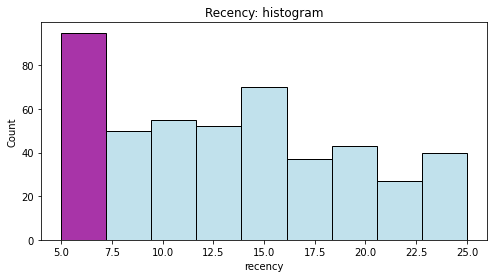

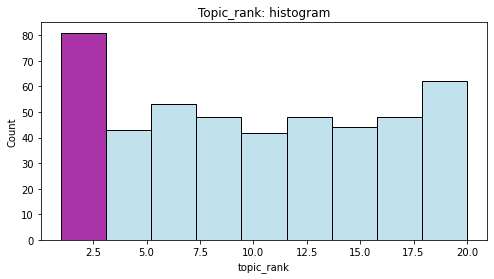

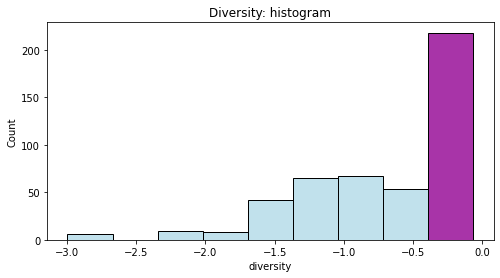

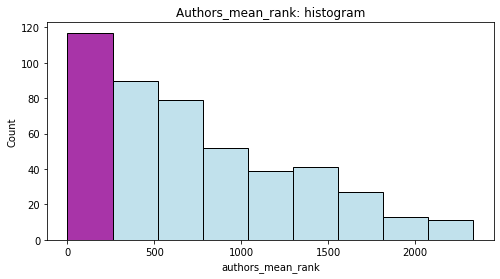

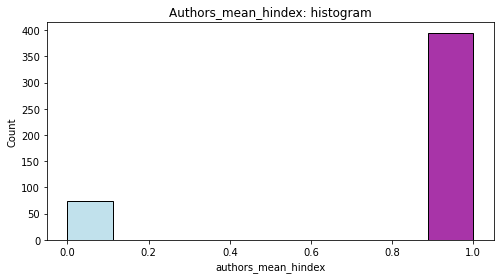

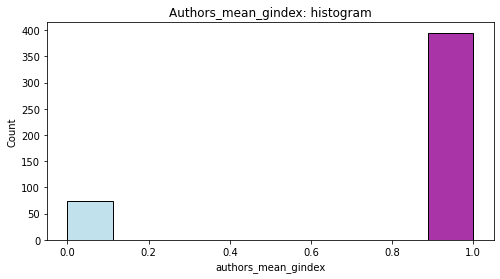

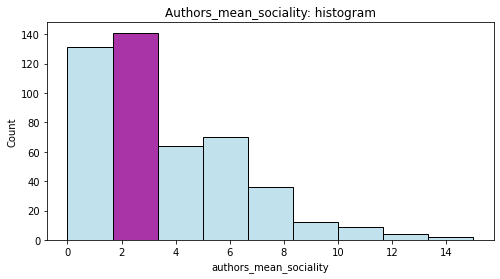

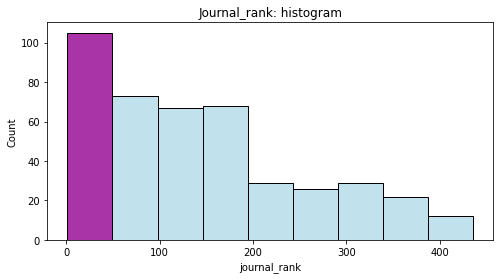

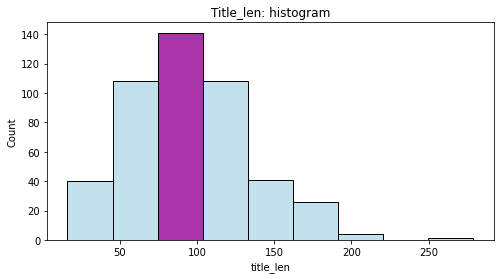

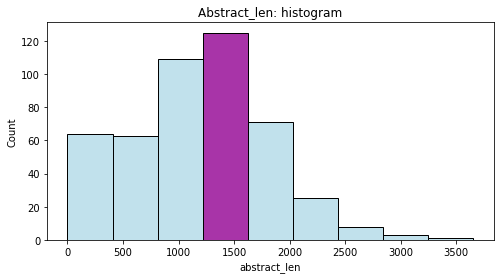

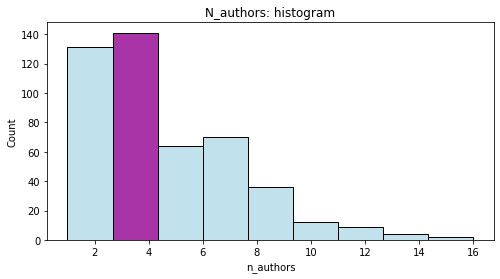

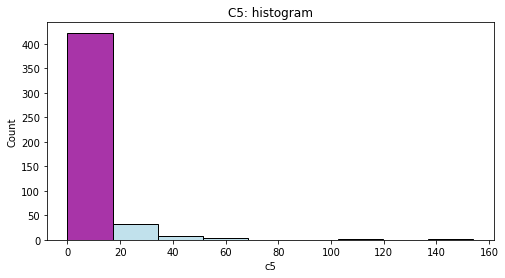

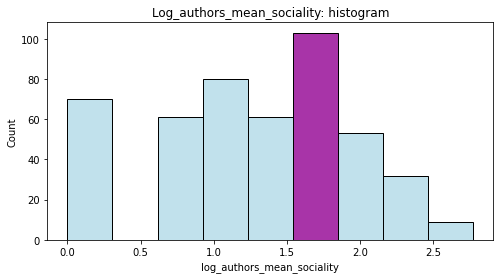

In [12]:
for col in df_preprocessed.columns:
    data_column_histogram(df_preprocessed_dropna, col)

Видим, что распределение целевой переменной `С5` не является нормальным. Посмотрим на коореляцию признаков с целевой переменной `c5`.

In [13]:
df_preprocessed_dropna.corr()['c5']

recency                      -0.207365
topic_rank                   -0.007175
diversity                     0.063071
authors_mean_rank            -0.355238
authors_mean_hindex           0.233550
authors_mean_gindex           0.233550
authors_mean_sociality        0.137201
journal_rank                 -0.360767
title_len                    -0.000866
abstract_len                  0.203857
n_authors                     0.137201
c5                            1.000000
log_authors_mean_sociality    0.107208
Name: c5, dtype: float64

Линейной зависимости между переменными и $с5$ тоже нет.

## 2. Подбор модели

### 2.1. `ExtraTreesRegressor`

In [14]:
def regressors_model(X, y, model):
    '''
    Fit Regressors
    '''
    regressors = []
    mean_r2_score = []
    importances_ = []
    for i in range(10):
        r2 = []
        ETR = model
        for train_index, test_index in cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            ETR.fit(X_train, y_train)
            r2.append(r2_score(y_true=y_test, 
                               y_pred=ETR.predict(X_test)))
            importances_.append(ETR.feature_importances_)
        regressors.append(ETR)
        print(f'iteration {i}, R2: {np.mean(r2)}')
        mean_r2_score.append(np.mean(r2))
    print(f'mean: {np.mean(mean_r2_score)}')
    return importances_, regressors

def classifiers_model(X, y, model):
    '''
    Fit Classifiers
    '''
    classifiers = []
    mean_accuracy_score, mean_auc, mean_f1 = [], [], []
    for i in range(10):
        accuracy_, roc_auc_score_, f1_score_ = [], [], []
        RFC = model
        for train_index, test_index in cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            RFC.fit(X_train, y_train)
            accuracy_.append(accuracy_score(y_true=y_test, 
                               y_pred=RFC.predict(X_test)))
            roc_auc_score_.append(roc_auc_score(y_true=y_test, 
                               y_score=RFC.predict(X_test)))
            f1_score_.append(f1_score(y_true=y_test, 
                               y_pred=RFC.predict(X_test)))
        classifiers.append(RFC)
        print(f'''Iteration {i}. 
        ACC: {np.mean(accuracy_):.4}
        ROC-AUC: {np.mean(roc_auc_score_):.4}
        F1-SCORE: {np.mean(f1_score_):.4}''')
        mean_accuracy_score.append(np.mean(accuracy_))
        mean_auc.append(np.mean(roc_auc_score_))
        mean_f1.append(np.mean(f1_score_))
    print(f'ACCURACY: {np.mean(mean_accuracy_score)}')
    print(f'AUC-SCORE: {np.mean(mean_auc)}')
    print(f'F1-SCORE: {np.mean(mean_f1)}')
    return classifiers

Будем использовать нелинейные методы, а именно обучим $10$ регрессов, состоящих из ансамбля решающих деревьев - разновидности случайного леса `ExtraTreesRegressor`

In [15]:
from sklearn.ensemble import ExtraTreesRegressor

В качестве кросс-валидационного метода будем использовать перекрёстную проверку по фолдам `KFold CV`:

In [16]:
from sklearn.model_selection import KFold

In [17]:
cv = KFold(n_splits=5, shuffle=True)

В качестве оценки качества модели будем использовать следующую функции ошибки:

- `R2` - коэффициент детерминации, доля объяснённой дисперсии:

$$R^2 = \frac{\sum\limits_{i=1}^n \left(\hat{y}_i - \bar{y}\right)^2}{\sum\limits_{i=1}^n \left(y_i - \bar{y}\right)^2}$$

In [18]:
from sklearn.metrics import r2_score

В более перевёдем нашии признаки и целевую переменную в привычное обозначение - удалим признак `journal_rank` из-за большого количества нулевых значений, а так же два признака, состоящих лишь из значений `0, 1`.

In [19]:
X_ = (
    df_preprocessed_dropna
    .drop(['c5', 
           'journal_rank', 
           'authors_mean_hindex', 
           'authors_mean_gindex'], 
          axis=1)
)
X = X_.values
y = df_preprocessed_dropna['c5'].values

In [20]:
importances_, regressors = regressors_model(X, y, ExtraTreesRegressor(n_estimators=500))

iteration 0, R2: 0.7129239947172893
iteration 1, R2: 0.6889553498412944
iteration 2, R2: 0.6851476330137121
iteration 3, R2: 0.6679774783976622
iteration 4, R2: 0.622602647595116
iteration 5, R2: 0.6681869371787059
iteration 6, R2: 0.6479489956805243
iteration 7, R2: 0.6824384244681243
iteration 8, R2: 0.6788587421550305
iteration 9, R2: 0.7010965868087552
mean: 0.6756136789856215


Среднее значение `R2` варьируется на кросс-валидации в пределах `0.65-0.69`. Исследуем важность признаков с помощью `feature importance` в деревьях - чем больше признак уменьшает неоднородность, тем он важнее.

In [21]:
df_importance = pd.DataFrame(data=np.array(importances_).mean(axis=0), 
                             index=X_.columns,
                             columns=['importance'])

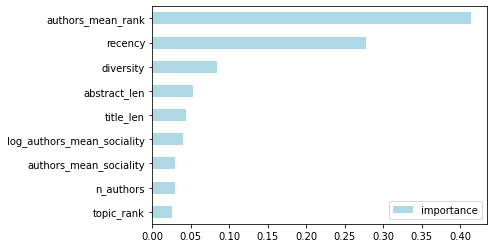

In [22]:
(
    df_importance
    .sort_values(by='importance')
    .plot
    .barh(color='lightblue')
)
plt.show()

Видим, что наиболее важными признаками в обученной модели являются `authors_mean_rank` и `recency` - чуть более подробно о смысле этих признаков надеюсь узнать далее.

Сохраняем модель - список обученных регрессоров. Ответ на тестовой выборке - среднее значение предсказаний регрессоров.

In [23]:
dump(regressors, "ETR_ensemble.joblib")

['ETR_ensemble.joblib']

### 2.2. `Binary Classification` + надстройка

Используем следующую идею - будем сначала предсказывать, какие статьи будут цитироваться, а какие нет - затем для статей, которые предсказаны в качестве `перспективных` настроим модель по предсказанию публикаций.

### 2.2.1 Classification - `Perspective / Non perspective`

Сформируем признаковое пространство.

In [24]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

Создадим новый признак целевой признак из нулей и единиц.

In [25]:
df_preprocessed_dropna['perspective'] = (
    df_preprocessed_dropna['c5']
    .where(df_preprocessed_dropna['c5'] == 0, 1)
)

In [26]:
X_classifier_ = (
    df_preprocessed_dropna
    .drop(['c5', 'perspective',  
           'journal_rank'], 
          axis=1)
)
X_classifier = X_classifier_.values
y = df_preprocessed_dropna['perspective'].values

In [27]:
_n = X_classifier.shape[1]

Подберем оптимальные параметры случайного леса по сетке.

In [28]:
parameters = {'max_features': np.arange(int(np.sqrt(_n)) - 2, int(np.sqrt(_n)) + 2), 
              'min_samples_leaf' : [1, 3, 5, 10]}

In [29]:
from sklearn.model_selection import GridSearchCV
estimator = ExtraTreesClassifier(n_estimators=500)
clf = GridSearchCV(estimator, parameters, cv=cv, scoring='accuracy')
clf.fit(X_classifier, y)
clf.best_estimator_

ExtraTreesClassifier(max_features=3, n_estimators=500)

Обучим классификатор.

In [30]:
classifiers = classifiers_model(X_classifier, y, ExtraTreesClassifier(n_estimators=500, max_features=3))

Iteration 0. 
        ACC: 0.904
        ROC-AUC: 0.8243
        F1-SCORE: 0.9389
Iteration 1. 
        ACC: 0.9061
        ROC-AUC: 0.829
        F1-SCORE: 0.94
Iteration 2. 
        ACC: 0.8976
        ROC-AUC: 0.8105
        F1-SCORE: 0.9345
Iteration 3. 
        ACC: 0.9063
        ROC-AUC: 0.8255
        F1-SCORE: 0.9401
Iteration 4. 
        ACC: 0.8998
        ROC-AUC: 0.8167
        F1-SCORE: 0.9361
Iteration 5. 
        ACC: 0.904
        ROC-AUC: 0.8275
        F1-SCORE: 0.9378
Iteration 6. 
        ACC: 0.9062
        ROC-AUC: 0.8262
        F1-SCORE: 0.9404
Iteration 7. 
        ACC: 0.9062
        ROC-AUC: 0.8205
        F1-SCORE: 0.9399
Iteration 8. 
        ACC: 0.904
        ROC-AUC: 0.8334
        F1-SCORE: 0.9377
Iteration 9. 
        ACC: 0.9041
        ROC-AUC: 0.8349
        F1-SCORE: 0.9367
ACCURACY: 0.9038435140700068
AUC-SCORE: 0.8248550431826599
F1-SCORE: 0.9382101794037458


Те объекты, которые были предсказаны в качестве $0$ - оставляем в качестве ответа алгоритма, те объекты, которые предсказаны в качестве перспективных - обучаем на второй модели - ансамбль регрессоров.

### 2.2.2. `Perspective Regression`

Формируем выборку без бесперспективных статей.

In [31]:
df_only_perspective = df_preprocessed_dropna[df_preprocessed_dropna['c5'] !=0]

In [32]:
X_only_perspective_ = (
    df_only_perspective
    .drop(['c5', 
           'perspective',
           'journal_rank'
          ], 
          axis=1)
)
X_only_perspective = X_only_perspective_.values
y_only_perspective = df_only_perspective['c5'].values

Обучаем модель на перспективных статьях.

In [33]:
importances_, regressors = regressors_model(X_only_perspective, y_only_perspective, ExtraTreesRegressor(n_estimators=500))

iteration 0, R2: 0.4865417562558977
iteration 1, R2: 0.6067962014967807
iteration 2, R2: 0.6154721734941055
iteration 3, R2: 0.6668759647553761
iteration 4, R2: 0.6333862359728275
iteration 5, R2: 0.6165651395453288
iteration 6, R2: 0.6830264318194087
iteration 7, R2: 0.620176362741636
iteration 8, R2: 0.6302354242041008
iteration 9, R2: 0.6382302462340721
mean: 0.6197305936519534


Результат получился хуже, чем в первой модели, но данную идею можно развивать.